In [2]:
import torch 
import torch.nn as nn 
import torch.optim as optim 

from PIL import Image, ImageFile 
ImageFile.LOAD_TRUNCATED_IMAGES = True

import albumentations as A 
from albumentations.pytorch import ToTensorV2 
import cv2 

import os 
import numpy as np 
import pandas as pd 

import matplotlib.pyplot as plt 
import matplotlib.patches as patches 

from tqdm import tqdm


### Utility Functions

In [3]:
def iou(box1, box2, is_pred=True): 
    if is_pred: 
        # IoU score for prediction and label 
        # box1 (prediction) and box2 (label) are both in [x, y, width, height] format 
          
        # Box coordinates of prediction 
        b1_x1 = box1[..., 0:1] - box1[..., 2:3] / 2
        b1_y1 = box1[..., 1:2] - box1[..., 3:4] / 2
        b1_x2 = box1[..., 0:1] + box1[..., 2:3] / 2
        b1_y2 = box1[..., 1:2] + box1[..., 3:4] / 2
  
        # Box coordinates of ground truth 
        b2_x1 = box2[..., 0:1] - box2[..., 2:3] / 2
        b2_y1 = box2[..., 1:2] - box2[..., 3:4] / 2
        b2_x2 = box2[..., 0:1] + box2[..., 2:3] / 2
        b2_y2 = box2[..., 1:2] + box2[..., 3:4] / 2
  
        # Get the coordinates of the intersection rectangle 
        x1 = torch.max(b1_x1, b2_x1) 
        y1 = torch.max(b1_y1, b2_y1) 
        x2 = torch.min(b1_x2, b2_x2) 
        y2 = torch.min(b1_y2, b2_y2) 
        # Make sure the intersection is at least 0 
        intersection = (x2 - x1).clamp(0) * (y2 - y1).clamp(0) 
  
        # Calculate the union area 
        box1_area = abs((b1_x2 - b1_x1) * (b1_y2 - b1_y1)) 
        box2_area = abs((b2_x2 - b2_x1) * (b2_y2 - b2_y1)) 
        union = box1_area + box2_area - intersection 
  
        # Calculate the IoU score 
        epsilon = 1e-6
        iou_score = intersection / (union + epsilon) 
  
        # Return IoU score 
        return iou_score 
      
    else: 
        # IoU score based on width and height of bounding boxes 
          
        # Calculate intersection area 
        intersection_area = torch.min(box1[..., 0], box2[..., 0]) * torch.min(box1[..., 1], box2[..., 1]) 
  
        # Calculate union area 
        box1_area = box1[..., 0] * box1[..., 1] 
        box2_area = box2[..., 0] * box2[..., 1] 
        union_area = box1_area + box2_area - intersection_area 
  
        # Calculate IoU score 
        iou_score = intersection_area / union_area 
  
        # Return IoU score 
        return iou_score

In [4]:
def nms(bboxes, iou_threshold, threshold): 
    # Filter out bounding boxes with confidence below the threshold. 
    bboxes = [box for box in bboxes if box[1] > threshold] 
  
    # Sort the bounding boxes by confidence in descending order. 
    bboxes = sorted(bboxes, key=lambda x: x[1], reverse=True) 
  
    # Initialize the list of bounding boxes after non-maximum suppression. 
    bboxes_nms = [] 
  
    while bboxes: 
        # Get the first bounding box. 
        first_box = bboxes.pop(0) 
  
        # Iterate over the remaining bounding boxes. 
        for box in bboxes: 
        # If the bounding boxes do not overlap or if the first bounding box has 
        # a higher confidence, then add the second bounding box to the list of 
        # bounding boxes after non-maximum suppression. 
            if box[0] != first_box[0] or iou( 
                torch.tensor(first_box[2:]), 
                torch.tensor(box[2:]), 
            ) < iou_threshold: 
                # Check if box is not in bboxes_nms 
                if box not in bboxes_nms: 
                    # Add box to bboxes_nms 
                    bboxes_nms.append(box) 
  
    # Return bounding boxes after non-maximum suppression. 
    return bboxes_nms

In [5]:
def convert_cells_to_bboxes(predictions, anchors, s, is_predictions=True): 
    # Batch size used on predictions 
    batch_size = predictions.shape[0] 
    # Number of anchors 
    num_anchors = len(anchors) 
    # List of all the predictions 
    box_predictions = predictions[..., 1:5] 
  
    # If the input is predictions then we will pass the x and y coordinate 
    # through sigmoid function and width and height to exponent function and 
    # calculate the score and best class. 
    if is_predictions: 
        anchors = anchors.reshape(1, len(anchors), 1, 1, 2) 
        box_predictions[..., 0:2] = torch.sigmoid(box_predictions[..., 0:2]) 
        box_predictions[..., 2:] = torch.exp( 
            box_predictions[..., 2:]) * anchors 
        scores = torch.sigmoid(predictions[..., 0:1]) 
        best_class = torch.argmax(predictions[..., 5:], dim=-1).unsqueeze(-1) 
      
    # Else we will just calculate scores and best class. 
    else: 
        scores = predictions[..., 0:1] 
        best_class = predictions[..., 5:6] 
  
    # Calculate cell indices 
    cell_indices = ( 
        torch.arange(s) 
        .repeat(predictions.shape[0], 3, s, 1) 
        .unsqueeze(-1) 
        .to(predictions.device) 
    ) 
  
    # Calculate x, y, width and height with proper scaling 
    x = 1 / s * (box_predictions[..., 0:1] + cell_indices) 
    y = 1 / s * (box_predictions[..., 1:2] +
                 cell_indices.permute(0, 1, 3, 2, 4)) 
    width_height = 1 / s * box_predictions[..., 2:4] 
  
    # Concatinating the values and reshaping them in 
    # (BATCH_SIZE, num_anchors * S * S, 6) shape 
    converted_bboxes = torch.cat( 
        (best_class, scores, x, y, width_height), dim=-1
    ).reshape(batch_size, num_anchors * s * s, 6) 
  
    # Returning the reshaped and converted bounding box list 
    return converted_bboxes.tolist()

In [6]:
 def plot_image(image, boxes): 
    # Getting the color map from matplotlib 
    colour_map = plt.get_cmap("tab20b") 
    # Getting 20 different colors from the color map for 20 different classes 
    colors = [colour_map(i) for i in np.linspace(0, 1, len(class_labels))] 
  
    # Reading the image with OpenCV 
    img = np.array(image) 
    # Getting the height and width of the image 
    h, w, _ = img.shape 
  
    # Create figure and axes 
    fig, ax = plt.subplots(1) 
  
    # Add image to plot 
    ax.imshow(img) 
  
    # Plotting the bounding boxes and labels over the image 
    for box in boxes: 
        # Get the class from the box 
        class_pred = box[0] 
        # Get the center x and y coordinates 
        box = box[2:] 
        # Get the upper left corner coordinates 
        upper_left_x = box[0] - box[2] / 2
        upper_left_y = box[1] - box[3] / 2
  
        # Create a Rectangle patch with the bounding box 
        rect = patches.Rectangle( 
            (upper_left_x * w, upper_left_y * h), 
            box[2] * w, 
            box[3] * h, 
            linewidth=2, 
            edgecolor=colors[int(class_pred)], 
            facecolor="none", 
        ) 
          
        # Add the patch to the Axes 
        ax.add_patch(rect) 
          
        # Add class name to the patch 
        plt.text( 
            upper_left_x * w, 
            upper_left_y * h, 
            s=class_labels[int(class_pred)], 
            color="white", 
            verticalalignment="top", 
            bbox={"color": colors[int(class_pred)], "pad": 0}, 
        ) 
  
    # Display the plot 
    plt.show()

In [7]:
def save_checkpoint(model, optimizer, filename="my_checkpoint.pth.tar"): 
    print("==> Saving checkpoint") 
    checkpoint = { 
        "state_dict": model.state_dict(), 
        "optimizer": optimizer.state_dict(), 
    } 
    torch.save(checkpoint, filename)

In [8]:
def load_checkpoint(checkpoint_file, model, optimizer, lr): 
    print("==> Loading checkpoint") 
    checkpoint = torch.load(checkpoint_file, map_location=device) 
    model.load_state_dict(checkpoint["state_dict"]) 
    optimizer.load_state_dict(checkpoint["optimizer"]) 
  
    for param_group in optimizer.param_groups: 
        param_group["lr"] = lr 

In [9]:
# Device 
device = "cuda" if torch.cuda.is_available() else "cpu"
  
# Load and save model variable 
load_model = False
save_model = True
  
# model checkpoint file name 
checkpoint_file = "checkpoint.pth.tar"
  
# Anchor boxes for each feature map scaled between 0 and 1 
# 3 feature maps at 3 different scales based on YOLOv3 paper 
ANCHORS = [ 
    [(0.28, 0.22), (0.38, 0.48), (0.9, 0.78)], 
    [(0.07, 0.15), (0.15, 0.11), (0.14, 0.29)], 
    [(0.02, 0.03), (0.04, 0.07), (0.08, 0.06)], 
] 
  
# Batch size for training 
batch_size = 32
  
# Learning rate for training 
leanring_rate = 1e-5
  
# Number of epochs for training 
epochs = 30
  
# Image size 
image_size = 416
  
# Grid cell sizes 
s = [image_size // 32, image_size // 16, image_size // 8] 
  
# Class labels 
class_labels = [ 
    "aeroplane", "bicycle", "bird", "boat", "bottle", "bus", "car", "cat", 
    "chair", "cow", "diningtable", "dog", "horse", "motorbike", "person", 
    "pottedplant", "sheep", "sofa", "train", "tvmonitor"
]

In [10]:

# Create a dataset class to load the images and labels from the folder 
class Dataset(torch.utils.data.Dataset): 
    def __init__( 
        self, csv_file, image_dir, label_dir, anchors,  
        image_size=416, grid_sizes=[13, 26, 52], 
        num_classes=20, transform=None
    ): 
        # Read the csv file with image names and labels 
        self.label_list = pd.read_csv(csv_file) 
        # Image and label directories 
        self.image_dir = image_dir 
        self.label_dir = label_dir 
        # Image size 
        self.image_size = image_size 
        # Transformations 
        self.transform = transform 
        # Grid sizes for each scale 
        self.grid_sizes = grid_sizes 
        # Anchor boxes 
        self.anchors = torch.tensor( 
            anchors[0] + anchors[1] + anchors[2]) 
        # Number of anchor boxes  
        self.num_anchors = self.anchors.shape[0] 
        # Number of anchor boxes per scale 
        self.num_anchors_per_scale = self.num_anchors // 3
        # Number of classes 
        self.num_classes = num_classes 
        # Ignore IoU threshold 
        self.ignore_iou_thresh = 0.5
  
    def __len__(self): 
        return len(self.label_list) 
      
    def __getitem__(self, idx): 
        # Getting the label path 
        label_path = os.path.join(self.label_dir, self.label_list.iloc[idx, 1]) 
        # We are applying roll to move class label to the last column 
        # 5 columns: x, y, width, height, class_label 
        bboxes = np.roll(np.loadtxt(fname=label_path, 
                         delimiter=" ", ndmin=2), 4, axis=1).tolist() 
          
        # Getting the image path 
        img_path = os.path.join(self.image_dir, self.label_list.iloc[idx, 0]) 
        image = np.array(Image.open(img_path).convert("RGB")) 
  
        # Albumentations augmentations 
        if self.transform: 
            augs = self.transform(image=image, bboxes=bboxes) 
            image = augs["image"] 
            bboxes = augs["bboxes"] 
  
        # Below assumes 3 scale predictions (as paper) and same num of anchors per scale 
        # target : [probabilities, x, y, width, height, class_label] 
        targets = [torch.zeros((self.num_anchors_per_scale, s, s, 6)) 
                   for s in self.grid_sizes] 
          
        # Identify anchor box and cell for each bounding box 
        for box in bboxes: 
            # Calculate iou of bounding box with anchor boxes 
            iou_anchors = iou(torch.tensor(box[2:4]),  
                              self.anchors,  
                              is_pred=False) 
            # Selecting the best anchor box 
            anchor_indices = iou_anchors.argsort(descending=True, dim=0) 
            x, y, width, height, class_label = box 
  
            # At each scale, assigning the bounding box to the  
            # best matching anchor box 
            has_anchor = [False] * 3
            for anchor_idx in anchor_indices: 
                scale_idx = anchor_idx // self.num_anchors_per_scale 
                anchor_on_scale = anchor_idx % self.num_anchors_per_scale 
                  
                # Identifying the grid size for the scale 
                s = self.grid_sizes[scale_idx] 
                  
                # Identifying the cell to which the bounding box belongs 
                i, j = int(s * y), int(s * x) 
                anchor_taken = targets[scale_idx][anchor_on_scale, i, j, 0] 
                  
                # Check if the anchor box is already assigned 
                if not anchor_taken and not has_anchor[scale_idx]: 
  
                    # Set the probability to 1 
                    targets[scale_idx][anchor_on_scale, i, j, 0] = 1
  
                    # Calculating the center of the bounding box relative 
                    # to the cell 
                    x_cell, y_cell = s * x - j, s * y - i  
  
                    # Calculating the width and height of the bounding box  
                    # relative to the cell 
                    width_cell, height_cell = (width * s, height * s) 
  
                    # Idnetify the box coordinates 
                    box_coordinates = torch.tensor( 
                                        [x_cell, y_cell, width_cell,  
                                         height_cell] 
                                    ) 
  
                    # Assigning the box coordinates to the target 
                    targets[scale_idx][anchor_on_scale, i, j, 1:5] = box_coordinates 
  
                    # Assigning the class label to the target 
                    targets[scale_idx][anchor_on_scale, i, j, 5] = int(class_label) 
  
                    # Set the anchor box as assigned for the scale 
                    has_anchor[scale_idx] = True
  
                # If the anchor box is already assigned, check if the  
                # IoU is greater than the threshold 
                elif not anchor_taken and iou_anchors[anchor_idx] > self.ignore_iou_thresh: 
                    # Set the probability to -1 to ignore the anchor box 
                    targets[scale_idx][anchor_on_scale, i, j, 0] = -1
  
        # Return the image and the target 
        return image, tuple(targets)

In [11]:
# Transform for training 
train_transform = A.Compose( 
    [ 
        # Rescale an image so that maximum side is equal to image_size 
        A.LongestMaxSize(max_size=image_size), 
        # Pad remaining areas with zeros 
        A.PadIfNeeded( 
            min_height=image_size, min_width=image_size, border_mode=cv2.BORDER_CONSTANT 
        ), 
        # Random color jittering 
        A.ColorJitter( 
            brightness=0.5, contrast=0.5, 
            saturation=0.5, hue=0.5, p=0.5
        ), 
        # Flip the image horizontally 
        A.HorizontalFlip(p=0.5), 
        # Normalize the image 
        A.Normalize( 
            mean=[0, 0, 0], std=[1, 1, 1], max_pixel_value=255
        ), 
        # Convert the image to PyTorch tensor 
        ToTensorV2() 
    ],  
    # Augmentation for bounding boxes 
    bbox_params=A.BboxParams( 
                    format="yolo",  
                    min_visibility=0.4,  
                    label_fields=[] 
                ) 
) 
  
# Transform for testing 
test_transform = A.Compose( 
    [ 
        # Rescale an image so that maximum side is equal to image_size 
        A.LongestMaxSize(max_size=image_size), 
        # Pad remaining areas with zeros 
        A.PadIfNeeded( 
            min_height=image_size, min_width=image_size, border_mode=cv2.BORDER_CONSTANT 
        ), 
        # Normalize the image 
        A.Normalize( 
            mean=[0, 0, 0], std=[1, 1, 1], max_pixel_value=255
        ), 
        # Convert the image to PyTorch tensor 
        ToTensorV2() 
    ], 
    # Augmentation for bounding boxes  
    bbox_params=A.BboxParams( 
                    format="yolo",  
                    min_visibility=0.4,  
                    label_fields=[] 
                ) 
)

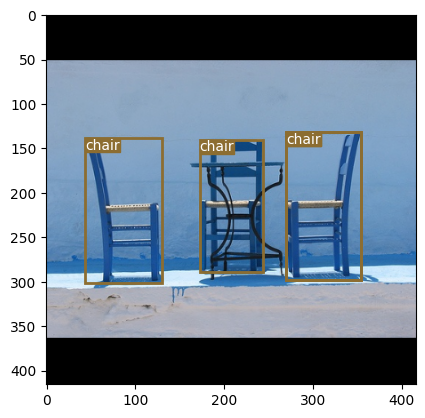

In [12]:
# Creating a dataset object 
dataset = Dataset( 
    csv_file="/kaggle/input/pascal-voc-dataset-used-in-yolov3-video/PASCAL_VOC/train.csv", 
    image_dir="/kaggle/input/pascal-voc-dataset-used-in-yolov3-video/PASCAL_VOC/images", 
    label_dir="/kaggle/input/pascal-voc-dataset-used-in-yolov3-video/PASCAL_VOC/labels", 
    grid_sizes=[13, 26, 52], 
    anchors=ANCHORS, 
    transform=test_transform 
) 
  
# Creating a dataloader object 
loader = torch.utils.data.DataLoader( 
    dataset=dataset, 
    batch_size=1, 
    shuffle=True, 
) 
  
# Defining the grid size and the scaled anchors 
GRID_SIZE = [13, 26, 52] 
scaled_anchors = torch.tensor(ANCHORS) / ( 
    1 / torch.tensor(GRID_SIZE).unsqueeze(1).unsqueeze(1).repeat(1, 3, 2) 
) 
  
# Getting a batch from the dataloader 
x, y = next(iter(loader)) 
  
# Getting the boxes coordinates from the labels 
# and converting them into bounding boxes without scaling 
boxes = [] 
for i in range(y[0].shape[1]): 
    anchor = scaled_anchors[i] 
    boxes += convert_cells_to_bboxes( 
               y[i], is_predictions=False, s=y[i].shape[2], anchors=anchor 
             )[0] 
  
# Applying non-maximum suppression 
boxes = nms(boxes, iou_threshold=1, threshold=0.7) 
  
# Plotting the image with the bounding boxes 
plot_image(x[0].permute(1,2,0).to("cpu"), boxes)

In [13]:
class CNNBlock(nn.Module): 
    def __init__(self, in_channels, out_channels, use_batch_norm=True, **kwargs): 
        super().__init__() 
        self.conv = nn.Conv2d(in_channels, out_channels, bias=not use_batch_norm, **kwargs) 
        self.bn = nn.BatchNorm2d(out_channels) 
        self.activation = nn.LeakyReLU(0.1) 
        self.use_batch_norm = use_batch_norm 
  
    def forward(self, x): 
        # Applying convolution 
        x = self.conv(x) 
        # Applying BatchNorm and activation if needed 
        if self.use_batch_norm: 
            x = self.bn(x) 
            return self.activation(x) 
        else: 
            return x

In [14]:
class ResidualBlock(nn.Module): 
    def __init__(self, channels, use_residual=True, num_repeats=1): 
        super().__init__() 
          
        # Defining all the layers in a list and adding them based on number of  
        # repeats mentioned in the design 
        res_layers = [] 
        for _ in range(num_repeats): 
            res_layers += [ 
                nn.Sequential( 
                    nn.Conv2d(channels, channels // 2, kernel_size=1), 
                    nn.BatchNorm2d(channels // 2), 
                    nn.LeakyReLU(0.1), 
                    nn.Conv2d(channels // 2, channels, kernel_size=3, padding=1), 
                    nn.BatchNorm2d(channels), 
                    nn.LeakyReLU(0.1) 
                ) 
            ] 
        self.layers = nn.ModuleList(res_layers) 
        self.use_residual = use_residual 
        self.num_repeats = num_repeats 
      
    # Defining forward pass 
    def forward(self, x): 
        for layer in self.layers: 
            residual = x 
            x = layer(x) 
            if self.use_residual: 
                x = x + residual 
        return x

In [16]:
class YOLOv3(nn.Module): 
    def __init__(self, in_channels=3, num_classes=21): 
        super().__init__() 
        self.num_classes = num_classes 
        self.in_channels = in_channels 
  
        # Layers list for YOLOv3 
        self.layers = nn.ModuleList([ 
            CNNBlock(in_channels, 32, kernel_size=3, stride=1, padding=1), 
            CNNBlock(32, 64, kernel_size=3, stride=2, padding=1), 
            ResidualBlock(64, num_repeats=1), 
            CNNBlock(64, 128, kernel_size=3, stride=2, padding=1), 
            ResidualBlock(128, num_repeats=2), 
            CNNBlock(128, 256, kernel_size=3, stride=2, padding=1), 
            ResidualBlock(256, num_repeats=8), 
            CNNBlock(256, 512, kernel_size=3, stride=2, padding=1), 
            ResidualBlock(512, num_repeats=8), 
            CNNBlock(512, 1024, kernel_size=3, stride=2, padding=1), 
            ResidualBlock(1024, num_repeats=4), 
            CNNBlock(1024, 512, kernel_size=1, stride=1, padding=0), 
            CNNBlock(512, 1024, kernel_size=3, stride=1, padding=1), 
            ResidualBlock(1024, use_residual=False, num_repeats=1), 
            CNNBlock(1024, 512, kernel_size=1, stride=1, padding=0), 
            ScalePrediction(512, num_classes=num_classes), 
            CNNBlock(512, 256, kernel_size=1, stride=1, padding=0), 
            nn.Upsample(scale_factor=2), 
            CNNBlock(768, 256, kernel_size=1, stride=1, padding=0), 
            CNNBlock(256, 512, kernel_size=3, stride=1, padding=1), 
            ResidualBlock(512, use_residual=False, num_repeats=1), 
            CNNBlock(512, 256, kernel_size=1, stride=1, padding=0), 
            ScalePrediction(256, num_classes=num_classes), 
            CNNBlock(256, 128, kernel_size=1, stride=1, padding=0), 
            nn.Upsample(scale_factor=2), 
            CNNBlock(384, 128, kernel_size=1, stride=1, padding=0), 
            CNNBlock(128, 256, kernel_size=3, stride=1, padding=1), 
            ResidualBlock(256, use_residual=False, num_repeats=1), 
            CNNBlock(256, 128, kernel_size=1, stride=1, padding=0), 
            ScalePrediction(128, num_classes=num_classes) 
        ]) 
      
    # Forward pass for YOLOv3 with route connections and scale predictions 
    def forward(self, x): 
        outputs = [] 
        route_connections = [] 
  
        for layer in self.layers: 
            if isinstance(layer, ScalePrediction): 
                outputs.append(layer(x)) 
                continue
            x = layer(x) 
  
            if isinstance(layer, ResidualBlock) and layer.num_repeats == 8: 
                route_connections.append(x) 
              
            elif isinstance(layer, nn.Upsample): 
                x = torch.cat([x, route_connections[-1]], dim=1) 
                route_connections.pop() 
        return outputs

In [17]:
if __name__ == "__main__": 
    # Setting number of classes and image size 
    num_classes = 21
    IMAGE_SIZE = 416
  
    # Creating model and testing output shapes 
    model = YOLOv3(num_classes=num_classes) 
    x = torch.randn((1, 3, IMAGE_SIZE, IMAGE_SIZE)) 
    out = model(x) 
    print(out[0].shape) 
    print(out[1].shape) 
    print(out[2].shape) 
  
    # Asserting output shapes 
    assert model(x)[0].shape == (1, 3, IMAGE_SIZE//32, IMAGE_SIZE//32, num_classes + 5) 
    assert model(x)[1].shape == (1, 3, IMAGE_SIZE//16, IMAGE_SIZE//16, num_classes + 5) 
    assert model(x)[2].shape == (1, 3, IMAGE_SIZE//8, IMAGE_SIZE//8, num_classes + 5) 
    print("Output shapes are correct!")

torch.Size([1, 3, 13, 13, 26])
torch.Size([1, 3, 26, 26, 26])
torch.Size([1, 3, 52, 52, 26])
Output shapes are correct!


In [18]:
class YOLOLoss(nn.Module): 
    def __init__(self): 
        super().__init__() 
        self.mse = nn.MSELoss() 
        self.bce = nn.BCEWithLogitsLoss() 
        self.cross_entropy = nn.CrossEntropyLoss() 
        self.sigmoid = nn.Sigmoid() 
      
    def forward(self, pred, target, anchors): 
        # Identifying which cells in target have objects  
        # and which have no objects 
        obj = target[..., 0] == 1
        no_obj = target[..., 0] == 0
  
        # Calculating No object loss 
        no_object_loss = self.bce( 
            (pred[..., 0:1][no_obj]), (target[..., 0:1][no_obj]), 
        ) 
  
          
        # Reshaping anchors to match predictions 
        anchors = anchors.reshape(1, 3, 1, 1, 2) 
        # Box prediction confidence 
        box_preds = torch.cat([self.sigmoid(pred[..., 1:3]), 
                               torch.exp(pred[..., 3:5]) * anchors 
                            ],dim=-1) 
        # Calculating intersection over union for prediction and target 
        ious = iou(box_preds[obj], target[..., 1:5][obj]).detach() 
        # Calculating Object loss 
        object_loss = self.mse(self.sigmoid(pred[..., 0:1][obj]), 
                               ious * target[..., 0:1][obj]) 
  
          
        # Predicted box coordinates 
        pred[..., 1:3] = self.sigmoid(pred[..., 1:3]) 
        # Target box coordinates 
        target[..., 3:5] = torch.log(1e-6 + target[..., 3:5] / anchors) 
        # Calculating box coordinate loss 
        box_loss = self.mse(pred[..., 1:5][obj], 
                            target[..., 1:5][obj]) 
  
          
        # Claculating class loss 
        class_loss = self.cross_entropy((pred[..., 5:][obj]), 
                                   target[..., 5][obj].long()) 
  
        # Total loss 
        return ( 
            box_loss 
            + object_loss 
            + no_object_loss 
            + class_loss 
        )

In [19]:
def training_loop(loader, model, optimizer, loss_fn, scaler, scaled_anchors): 
    # Creating a progress bar 
    progress_bar = tqdm(loader, leave=True) 
  
    # Initializing a list to store the losses 
    losses = [] 
  
    # Iterating over the training data 
    for _, (x, y) in enumerate(progress_bar): 
        x = x.to(device) 
        y0, y1, y2 = ( 
            y[0].to(device), 
            y[1].to(device), 
            y[2].to(device), 
        ) 
  
        with torch.cuda.amp.autocast(): 
            # Getting the model predictions 
            outputs = model(x) 
            # Calculating the loss at each scale 
            loss = ( 
                  loss_fn(outputs[0], y0, scaled_anchors[0]) 
                + loss_fn(outputs[1], y1, scaled_anchors[1]) 
                + loss_fn(outputs[2], y2, scaled_anchors[2]) 
            ) 
  
        # Add the loss to the list 
        losses.append(loss.item()) 
  
        # Reset gradients 
        optimizer.zero_grad() 
  
        # Backpropagate the loss 
        scaler.scale(loss).backward() 
  
        # Optimization step 
        scaler.step(optimizer) 
  
        # Update the scaler for next iteration 
        scaler.update() 
  
        # update progress bar with loss 
        mean_loss = sum(losses) / len(losses) 
        progress_bar.set_postfix(loss=mean_loss)
    return mean_loss

In [ ]:
model = YOLOv3().to(device) 
  
# Defining the optimizer 
optimizer = optim.Adam(model.parameters(), lr = leanring_rate) 
  
# Defining the loss function 
loss_fn = YOLOLoss() 
  
# Defining the scaler for mixed precision training 
scaler = torch.cuda.amp.GradScaler() 
  
# Defining the train dataset 
train_dataset = Dataset( 
    csv_file="/kaggle/input/pascal-voc-dataset-used-in-yolov3-video/PASCAL_VOC/train.csv", 
    image_dir="/kaggle/input/pascal-voc-dataset-used-in-yolov3-video/PASCAL_VOC/images", 
    label_dir="/kaggle/input/pascal-voc-dataset-used-in-yolov3-video/PASCAL_VOC/labels",
    anchors=ANCHORS, 
    transform=train_transform 
) 
  
# Defining the train data loader 
train_loader = torch.utils.data.DataLoader( 
    train_dataset, 
    batch_size = batch_size, 
    num_workers = 2, 
    shuffle = True, 
    pin_memory = True, 
) 
  
# Scaling the anchors 
scaled_anchors = ( 
    torch.tensor(ANCHORS) * 
    torch.tensor(s).unsqueeze(1).unsqueeze(1).repeat(1,3,2) 
).to(device) 
  
# Training the model 
losses=[]
for e in range(1, epochs+1): 
    print("Epoch:", e) 
    loss=training_loop(train_loader, model, optimizer, loss_fn, scaler, scaled_anchors)
    losses.append(loss)
    loss
    # Saving the model 
    if save_model: 
        save_checkpoint(model, optimizer, filename=f"checkpoint.pth.tar")

Epoch: 1


100%|██████████| 518/518 [05:58<00:00,  1.44it/s, loss=10.9]


==> Saving checkpoint

Epoch: 2


100%|██████████| 518/518 [05:58<00:00,  1.44it/s, loss=8.88]


==> Saving checkpoint

Epoch: 3


100%|██████████| 518/518 [05:58<00:00,  1.44it/s, loss=8.17]


==> Saving checkpoint

Epoch: 4


100%|██████████| 518/518 [05:58<00:00,  1.45it/s, loss=7.66]


==> Saving checkpoint

Epoch: 5


100%|██████████| 518/518 [05:57<00:00,  1.45it/s, loss=7.22]


==> Saving checkpoint

Epoch: 6


100%|██████████| 518/518 [05:57<00:00,  1.45it/s, loss=6.81]


==> Saving checkpoint

Epoch: 7


100%|██████████| 518/518 [05:58<00:00,  1.45it/s, loss=6.43]


==> Saving checkpoint

Epoch: 8


100%|██████████| 518/518 [05:57<00:00,  1.45it/s, loss=6.08]


==> Saving checkpoint

Epoch: 9


100%|██████████| 518/518 [05:57<00:00,  1.45it/s, loss=5.75]


==> Saving checkpoint

Epoch: 10


100%|██████████| 518/518 [05:58<00:00,  1.45it/s, loss=5.42]


==> Saving checkpoint

Epoch: 11


100%|██████████| 518/518 [05:57<00:00,  1.45it/s, loss=5.14]


==> Saving checkpoint

Epoch: 12


100%|██████████| 518/518 [05:57<00:00,  1.45it/s, loss=4.88]


==> Saving checkpoint

Epoch: 13


100%|██████████| 518/518 [05:58<00:00,  1.45it/s, loss=4.62]


==> Saving checkpoint

Epoch: 14


100%|██████████| 518/518 [05:57<00:00,  1.45it/s, loss=4.39]


==> Saving checkpoint

Epoch: 15


100%|██████████| 518/518 [05:58<00:00,  1.45it/s, loss=4.14]


==> Saving checkpoint

Epoch: 16


100%|██████████| 518/518 [05:58<00:00,  1.44it/s, loss=3.9] 


==> Saving checkpoint

Epoch: 17


100%|██████████| 518/518 [05:57<00:00,  1.45it/s, loss=3.68]


==> Saving checkpoint

Epoch: 18


100%|██████████| 518/518 [05:58<00:00,  1.45it/s, loss=3.39]


==> Saving checkpoint

Epoch: 19


100%|██████████| 518/518 [05:58<00:00,  1.45it/s, loss=3.18]


==> Saving checkpoint

Epoch: 20


100%|██████████| 518/518 [05:58<00:00,  1.45it/s, loss=2.95]


==> Saving checkpoint

Epoch: 21


100%|██████████| 518/518 [05:57<00:00,  1.45it/s, loss=2.75]


==> Saving checkpoint

Epoch: 22


100%|██████████| 518/518 [05:58<00:00,  1.45it/s, loss=2.54]


==> Saving checkpoint

Epoch: 23


100%|██████████| 518/518 [05:58<00:00,  1.45it/s, loss=2.34]


==> Saving checkpoint

Epoch: 24


100%|██████████| 518/518 [05:58<00:00,  1.44it/s, loss=2.14]


==> Saving checkpoint

Epoch: 25


100%|██████████| 518/518 [05:58<00:00,  1.44it/s, loss=2.02]


==> Saving checkpoint

Epoch: 26


100%|██████████| 518/518 [05:58<00:00,  1.45it/s, loss=1.89]


==> Saving checkpoint

Epoch: 27


100%|██████████| 518/518 [05:58<00:00,  1.45it/s, loss=1.76]


==> Saving checkpoint

Epoch: 28


 95%|█████████▍| 491/518 [05:40<00:18,  1.45it/s, loss=1.65]

In [ ]:
# loading checkingpoints 

def load_checkpoint(filepath):
    checkpoint = torch.load(filepath)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
    epoch = checkpoint['epoch']
    val_acc = checkpoint['val_acc']
    return model, optimizer, scheduler, epoch, val_acc

,loss
epoch,
1,10.915352
2,8.882402
3,8.174887
4,7.663731
5,7.216707
6,6.808088
7,6.425949
8,6.075394
9,5.747131


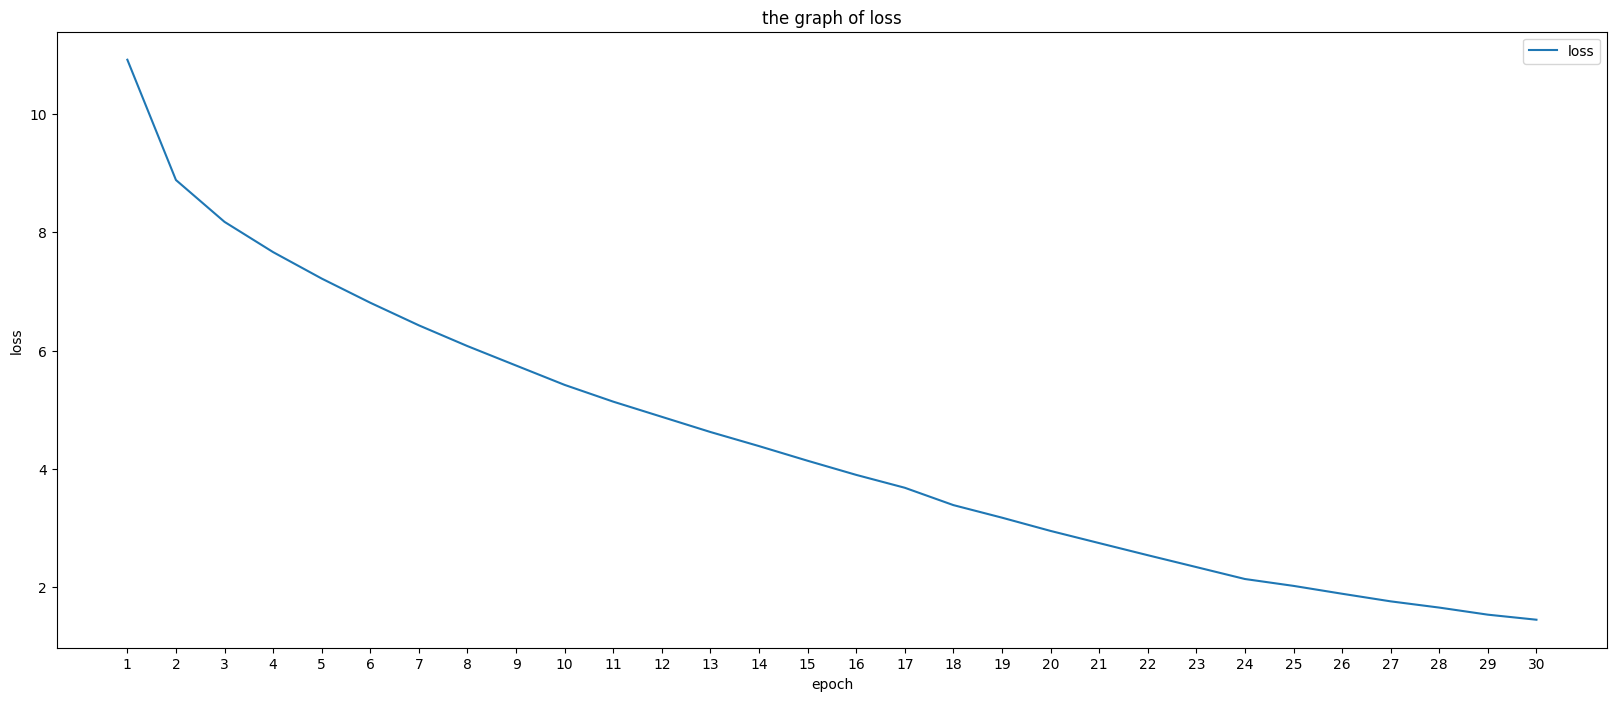

In [46]:
# putting losses in a dataframe
loss_df= pd.DataFrame({"epoch": range(1,31), "loss": losses})
loss_df.set_index('epoch', inplace=True)
display(loss_df)

#plotting losses
loss_df.plot(figsize=(20,8))
plt.ylabel('loss')
plt.xticks(range(1, 31))
plt.title("the graph of loss")
plt.show()

In [21]:
import os
import shutil

label_dir= "/kaggle/input/pascal-voc-dataset-used-in-yolov3-video/PASCAL_VOC/labels"

labels=[]
for root,dirs, files in os.walk(label_dir):
    #print(files)
    for label in files:
        labels.append(label)
        
        
labels_path= "./labels"

if not os.path.exists(labels_path):
    os.makedirs(labels_path)
    
for label_file in labels:
    src_path = os.path.join(label_dir, label_file)
    dst_path = os.path.join(labels_path, label_file)
    shutil.copy(src_path, dst_path)

for root, dirs, files in os.walk("/kaggle/working/labels"):
    print(len(files))


21503


In [22]:
new_labels_dir = "/kaggle/input/additional-new-data/obj_train_data"

# Ensure the output directory exists
if not os.path.exists(labels_path):
    os.makedirs(labels_path)

# Process label file
for root, dirs, files in os.walk(new_labels_dir):
    for file_name in files:
        with open(os.path.join(new_labels_dir, file_name), "r") as file:
            lines = file.readlines()
            updated_lines = []
            for line in lines:
                content = line.strip().split()
                if len(content) > 0:
                    content[0] = '20'  # Assuming you're updating the first value
                    # Ensure bounding box coordinates are within the range [0.0, 1.0]
                    for i in range(1, len(content)):  # Skipping the class label
                        value = float(content[i])
                        if value < 0.0:
                            content[i] = '0.0'
                        elif value > 1.0:
                            content[i] = '1.0'
                updated_lines.append(" ".join(content) + "\n")
                
            # Write updated lines to the output file
            with open(os.path.join(labels_path, file_name), "w") as output_file:
                output_file.writelines(updated_lines)

print(f"The files are saved successfully to {labels_path}")

# Count the number of files in the output directory
for root, dirs, files in os.walk("/kaggle/working/labels"):
    print(len(files))


The files are saved successfully to ./labels
21586


In [24]:
import os

new_labels_dir = "/kaggle/input/additional-new-labels/obj_train_data"
output_labels_dir = "/kaggle/working/labels"  # Define your output directory here

# Ensure the output directory exists
if not os.path.exists(output_labels_dir):
    os.makedirs(output_labels_dir)

# Process label files
for root, dirs, files in os.walk(new_labels_dir):
    for file_name in files:
        with open(os.path.join(new_labels_dir, file_name), "r") as file:
            lines = file.readlines()
            updated_lines = []
            has_negative_value = False  # Flag to check if there's a negative value
            for line in lines:
                content = line.strip().split()
                if len(content) > 0:
                    content[0] = '20'  # Assuming you're updating the first value
                    # Ensure bounding box coordinates are within the range [0.0, 1.0]
                    for i in range(1, len(content)):  # Skipping the class label
                        value = float(content[i])
                        if value < 0.0:
                            has_negative_value = True
                            break  # Break out of the loop if negative value found
                        elif value > 1.0:
                            content[i] = '1.0'
                updated_lines.append(" ".join(content) + "\n")
            
            # Write updated lines to the output file if no negative values found
            if not has_negative_value:
                with open(os.path.join(output_labels_dir, file_name), "w") as output_file:
                    output_file.writelines(updated_lines)
                #print("no negative value is present")
            else:
                print(f"File {file_name} contains negative values and has been removed.")

# Count the number of files in the output directory
num_files = sum(len(files) for _, _, files in os.walk(output_labels_dir))
print(f"Total number of files in the output directory: {num_files}")

Total number of files in the output directory: 21586


In [25]:
import os
import shutil

# Gather all images
prev_images = []

csv_file="/kaggle/input/pascal-voc-dataset-used-in-yolov3-video/PASCAL_VOC/train.csv"
image_dir="/kaggle/input/pascal-voc-dataset-used-in-yolov3-video/PASCAL_VOC/images"
label_dir="/kaggle/input/pascal-voc-dataset-used-in-yolov3-video/PASCAL_VOC/labels"

for root, dirs, files in os.walk(image_dir):
    images1 = files
    print(len(files))
    for img1_file in images1:
        if img1_file.endswith(".jpg") or img1_file.endswith(".png"):
            prev_images.append(img1_file)
            
        

# Define the path for the directory to save the images
images_path = "/kaggle/working/all images"

# Create the target directory if it doesn't exist
if not os.path.exists(images_path):
    os.makedirs(images_path)

# Copy each image file to the specified path
for img_file in prev_images:
    src_path = os.path.join(image_dir, img_file)
    dst_path = os.path.join(images_path, img_file)
    shutil.copy(src_path, dst_path)
    
for root, dirs, files in os.walk("/kaggle/working/all images"):
    print(len(files))
    


43223
43223


In [27]:
new_images=[]
image_dir="/kaggle/input/additional-images"
for root1, dirs1, files1 in os.walk(image_dir):
    #print(len(files1))
    for img2_file in files1:
        if img2_file.endswith(".jpg") or img2_file.endswith(".png"):
            new_images.append(img2_file)

images_path = "/kaggle/working/all images"
# Create the target directory if it doesn't exist
if not os.path.exists(images_path):
    os.makedirs(images_path)

# Copy each image file to the specified path
for img_file in new_images:
    src_path = os.path.join(image_dir, img_file)
    dst_path = os.path.join(images_path, img_file)
    shutil.copy(src_path, dst_path)

for root, dirs, files in os.walk("/kaggle/working/all images"):
    print(len(files))

43244


In [28]:
# import os
# import shutil

# more_images = []
# image_dir = "/kaggle/input/face-detection-dataset/images/train"

# # Loop through image files and select only the first 300 images
# count = 0
# for root1, dirs1, files1 in os.walk(image_dir):
#     for img2_file in files1:
#         if img2_file.endswith(".jpg") or img2_file.endswith(".png"):
#             more_images.append(img2_file)
#             count += 1
#             if count >= 300:
#                 break  # Exit the loop if 300 images have been selected

# images_path = "/kaggle/working/all images"
# # Create the target directory if it doesn't exist
# if not os.path.exists(images_path):
#     os.makedirs(images_path)

# # Copy each selected image file to the specified path
# for img_file in more_images:
#     src_path = os.path.join(image_dir, img_file)
#     dst_path = os.path.join(images_path, img_file)
#     shutil.copy(src_path, dst_path)

# print(f"Images saved to: {images_path}")
# print(f"Number of images copied: {len(more_images)}")

# for root, dirs, files in os.walk("/kaggle/working/all images"):
#     print(len(files))


In [29]:

csv_path='/kaggle/working/train.csv'
with open("/kaggle/input/pascal-voc-dataset-used-in-yolov3-video/PASCAL_VOC/train.csv", "r")as f:
    content=f.read()
with open(csv_path, "a") as file:
    file.write(content)
    print(f"the file is written to {csv_path} successfully")

the file is written to /kaggle/working/train.csv successfully


In [30]:
import pandas as pd
import csv
import os
data = []

for images_tuple, labels_tuple in zip(os.walk("/kaggle/input/additional-images"), os.walk("/kaggle/input/additional-new-data/obj_train_data")):
    images = images_tuple[2]
    labels = labels_tuple[2]
    for image_file, label_f in zip(images, labels):
        label_file = os.path.join(labels_tuple[0], label_f)
        if os.path.exists(label_file):
            with open(label_file, 'r') as f:
                label = f.read().strip()
                data.append((image_file, label_f))

# Define the path for the CSV file in the writable directory
csv_path1 = "/kaggle/working/additional_train.csv"

# Write data to CSV file
with open(csv_path1, 'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerows(data)

print("CSV file created successfully.")

pd.read_csv(csv_path1)
    



CSV file created successfully.


,p1125798_53589080964_o.jpg,p1051313_53583641500_o.txt
0,p1125721_53589202105_o.jpg,p1051088_53581395545_o.txt
1,p1125703_53589079319_o.jpg,p1125518_53580948561_o.txt
2,p1125758_53587889357_o.jpg,p1125583_53583511799_o.txt
3,p1125726_53589202695_o.jpg,p1051352_53583189886_o.txt
4,p1125815_53587890247_o.jpg,p1125629_53583510644_o.txt
5,p1125743_53588760891_o.jpg,p1051135_53581273169_o.txt
6,p1125732_53589202585_o.jpg,p1051177_53580076467_o.txt
7,p1125806_53589204090_o.jpg,p1051234_53583419468_o.txt
8,p1125734_53588760346_o.jpg,p1051107_53581395015_o.txt
9,p1125791_53588968543_o.jpg,p1125455_53580084052_o.txt


In [41]:
with open (csv_path1, "r") as file:
    content=file.read()
with open(csv_path, "a") as f:
    f.write(content)
    print(f"new csv is written to {csv_path} successfully")

new csv is written to /kaggle/working/train.csv successfully


In [42]:
class_labels

['aeroplane',
 'bicycle',
 'bird',
 'boat',
 'bottle',
 'bus',
 'car',
 'cat',
 'chair',
 'cow',
 'diningtable',
 'dog',
 'horse',
 'motorbike',
 'person',
 'pottedplant',
 'sheep',
 'sofa',
 'train',
 'tvmonitor']

In [43]:
updated_class_labels=class_labels
updated_class_labels.append("face")



In [44]:
updated_class_labels

['aeroplane',
 'bicycle',
 'bird',
 'boat',
 'bottle',
 'bus',
 'car',
 'cat',
 'chair',
 'cow',
 'diningtable',
 'dog',
 'horse',
 'motorbike',
 'person',
 'pottedplant',
 'sheep',
 'sofa',
 'train',
 'tvmonitor',
 'face']

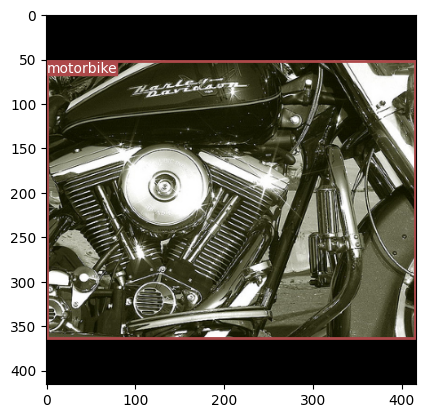

In [45]:
# Creating a dataset object 
dataset = Dataset( 
    csv_file="/kaggle/working/train.csv", 
    image_dir="/kaggle/working/all images", 
    label_dir="/kaggle/working/labels", 
    grid_sizes=[13, 26, 52], 
    anchors=ANCHORS, 
    transform=test_transform 
) 
  
# Creating a dataloader object 
loader = torch.utils.data.DataLoader( 
    dataset=dataset, 
    batch_size=1, 
    shuffle=True, 
) 
  
# Defining the grid size and the scaled anchors 
GRID_SIZE = [13, 26, 52] 
scaled_anchors = torch.tensor(ANCHORS) / ( 
    1 / torch.tensor(GRID_SIZE).unsqueeze(1).unsqueeze(1).repeat(1, 3, 2) 
) 
  
# Getting a batch from the dataloader 
x, y = next(iter(loader)) 
  
# Getting the boxes coordinates from the labels 
# and converting them into bounding boxes without scaling 
boxes = [] 
for i in range(y[0].shape[1]): 
    anchor = scaled_anchors[i] 
    boxes += convert_cells_to_bboxes( 
               y[i], is_predictions=False, s=y[i].shape[2], anchors=anchor 
             )[0] 
  
# Applying non-maximum suppression 
boxes = nms(boxes, iou_threshold=1, threshold=0.7) 
  
# Plotting the image with the bounding boxes 
plot_image(x[0].permute(1,2,0).to("cpu"), boxes)

In [46]:
 def plot_image(image, boxes): 
    # Getting the color map from matplotlib 
    colour_map = plt.get_cmap("tab20b") 
    # Getting 20 different colors from the color map for 20 different classes 
    colors = [colour_map(i) for i in np.linspace(0, 1, len(updated_class_labels))] 
  
    # Reading the image with OpenCV 
    img = np.array(image) 
    # Getting the height and width of the image 
    h, w, _ = img.shape 
  
    # Create figure and axes 
    fig, ax = plt.subplots(1) 
  
    # Add image to plot 
    ax.imshow(img) 
  
    # Plotting the bounding boxes and labels over the image 
    for box in boxes: 
        # Get the class from the box 
        class_pred = box[0] 
        # Get the center x and y coordinates 
        box = box[2:] 
        # Get the upper left corner coordinates 
        upper_left_x = box[0] - box[2] / 2
        upper_left_y = box[1] - box[3] / 2
  
        # Create a Rectangle patch with the bounding box 
        rect = patches.Rectangle( 
            (upper_left_x * w, upper_left_y * h), 
            box[2] * w, 
            box[3] * h, 
            linewidth=2, 
            edgecolor=colors[int(class_pred)], 
            facecolor="none", 
        ) 
          
        # Add the patch to the Axes 
        ax.add_patch(rect) 
          
        # Add class name to the patch 
        plt.text( 
            upper_left_x * w, 
            upper_left_y * h, 
            s=class_labels[int(class_pred)], 
            color="white", 
            verticalalignment="top", 
            bbox={"color": colors[int(class_pred)], "pad": 0}, 
        ) 
  
    # Display the plot 
    plt.show()

In [47]:
model = YOLOv3().to(device) 
  
# Defining the optimizer 
optimizer = optim.Adam(model.parameters(), lr = leanring_rate) 
  
# Defining the loss function 
loss_fn = YOLOLoss() 
  
# Defining the scaler for mixed precision training 
scaler = torch.cuda.amp.GradScaler() 
  
# Defining the train dataset 
train_dataset = Dataset( 
    csv_file="/kaggle/working/train.csv", 
    image_dir="/kaggle/working/all images", 
    label_dir="/kaggle/working/labels",
    anchors=ANCHORS, 
    transform=train_transform 
) 
  
# Defining the train data loader 
train_loader = torch.utils.data.DataLoader( 
    train_dataset, 
    batch_size = batch_size, 
    num_workers = 2, 
    shuffle = True, 
    pin_memory = True, 
) 
  
# Scaling the anchors 
scaled_anchors = ( 
    torch.tensor(ANCHORS) * 
    torch.tensor(s).unsqueeze(1).unsqueeze(1).repeat(1,3,2) 
).to(device) 
  
# Training the model 
losses=[]
for e in range(1, epochs+1): 
    print("Epoch:", e) 
    loss=training_loop(train_loader, model, optimizer, loss_fn, scaler, scaled_anchors)
    losses.append(loss)
    # Saving the model 
    if save_model: 
        save_checkpoint(model, optimizer, filename=f"checkpoint.pth.tar")

Epoch: 1


  0%|          | 0/525 [00:00<?, ?it/s]/tmp/ipykernel_34/3141741589.py:39: UserWarning: loadtxt: input contained no data: "/kaggle/working/labels/p1051088_53581395545_o.txt"
  bboxes = np.roll(np.loadtxt(fname=label_path,
/tmp/ipykernel_34/3141741589.py:39: UserWarning: loadtxt: input contained no data: "/kaggle/working/labels/p1125583_53583511799_o.txt"
  bboxes = np.roll(np.loadtxt(fname=label_path,
  0%|          | 2/525 [00:05<18:58,  2.18s/it, loss=14.6]/tmp/ipykernel_34/3141741589.py:39: UserWarning: loadtxt: input contained no data: "/kaggle/working/labels/p1051313_53583641500_o.txt"
  bboxes = np.roll(np.loadtxt(fname=label_path,
/tmp/ipykernel_34/3141741589.py:39: UserWarning: loadtxt: input contained no data: "/kaggle/working/labels/p1051234_53583419468_o.txt"
  bboxes = np.roll(np.loadtxt(fname=label_path,
  1%|          | 3/525 [00:05<12:37,  1.45s/it, loss=14.7]/tmp/ipykernel_34/3141741589.py:39: UserWarning: loadtxt: input contained no data: "/kaggle/working/labels/p11254

==> Saving checkpoint
Epoch: 2


  0%|          | 0/525 [00:00<?, ?it/s]/tmp/ipykernel_34/3141741589.py:39: UserWarning: loadtxt: input contained no data: "/kaggle/working/labels/p1125629_53583510644_o.txt"
  bboxes = np.roll(np.loadtxt(fname=label_path,
/tmp/ipykernel_34/3141741589.py:39: UserWarning: loadtxt: input contained no data: "/kaggle/working/labels/p1051310_53582325247_o.txt"
  bboxes = np.roll(np.loadtxt(fname=label_path,
  0%|          | 1/525 [00:01<10:07,  1.16s/it, loss=9.4]/tmp/ipykernel_34/3141741589.py:39: UserWarning: loadtxt: input contained no data: "/kaggle/working/labels/p1051337_53583516834_o.txt"
  bboxes = np.roll(np.loadtxt(fname=label_path,
  1%|          | 3/525 [00:02<06:50,  1.27it/s, loss=9.12]/tmp/ipykernel_34/3141741589.py:39: UserWarning: loadtxt: input contained no data: "/kaggle/working/labels/p1051135_53581273169_o.txt"
  bboxes = np.roll(np.loadtxt(fname=label_path,
  1%|          | 4/525 [00:03<06:23,  1.36it/s, loss=9.13]/tmp/ipykernel_34/3141741589.py:39: UserWarning: loadtxt

==> Saving checkpoint
Epoch: 3


  0%|          | 0/525 [00:00<?, ?it/s]/tmp/ipykernel_34/3141741589.py:39: UserWarning: loadtxt: input contained no data: "/kaggle/working/labels/p1125629_53583510644_o.txt"
  bboxes = np.roll(np.loadtxt(fname=label_path,
/tmp/ipykernel_34/3141741589.py:39: UserWarning: loadtxt: input contained no data: "/kaggle/working/labels/p1125470_53581272109_o.txt"
  bboxes = np.roll(np.loadtxt(fname=label_path,
  0%|          | 1/525 [00:01<10:55,  1.25s/it, loss=7.6]/tmp/ipykernel_34/3141741589.py:39: UserWarning: loadtxt: input contained no data: "/kaggle/working/labels/p1125455_53580084052_o.txt"
  bboxes = np.roll(np.loadtxt(fname=label_path,
  0%|          | 2/525 [00:01<07:55,  1.10it/s, loss=8.01]/tmp/ipykernel_34/3141741589.py:39: UserWarning: loadtxt: input contained no data: "/kaggle/working/labels/p1051290_53583520509_o.txt"
  bboxes = np.roll(np.loadtxt(fname=label_path,
  1%|          | 3/525 [00:02<07:21,  1.18it/s, loss=7.97]/tmp/ipykernel_34/3141741589.py:39: UserWarning: loadtxt

==> Saving checkpoint
Epoch: 4


  0%|          | 0/525 [00:00<?, ?it/s]/tmp/ipykernel_34/3141741589.py:39: UserWarning: loadtxt: input contained no data: "/kaggle/working/labels/p1125518_53580948561_o.txt"
  bboxes = np.roll(np.loadtxt(fname=label_path,
/tmp/ipykernel_34/3141741589.py:39: UserWarning: loadtxt: input contained no data: "/kaggle/working/labels/p1051234_53583419468_o.txt"
  bboxes = np.roll(np.loadtxt(fname=label_path,
/tmp/ipykernel_34/3141741589.py:39: UserWarning: loadtxt: input contained no data: "/kaggle/working/labels/p1051107_53581395015_o.txt"
  bboxes = np.roll(np.loadtxt(fname=label_path,
  1%|          | 6/525 [00:05<06:26,  1.34it/s, loss=7.77]/tmp/ipykernel_34/3141741589.py:39: UserWarning: loadtxt: input contained no data: "/kaggle/working/labels/p1051290_53583520509_o.txt"
  bboxes = np.roll(np.loadtxt(fname=label_path,
  1%|▏         | 7/525 [00:06<06:13,  1.39it/s, loss=7.66]/tmp/ipykernel_34/3141741589.py:39: UserWarning: loadtxt: input contained no data: "/kaggle/working/labels/p10513

==> Saving checkpoint
Epoch: 5


  0%|          | 0/525 [00:00<?, ?it/s]/tmp/ipykernel_34/3141741589.py:39: UserWarning: loadtxt: input contained no data: "/kaggle/working/labels/p1125470_53581272109_o.txt"
  bboxes = np.roll(np.loadtxt(fname=label_path,
/tmp/ipykernel_34/3141741589.py:39: UserWarning: loadtxt: input contained no data: "/kaggle/working/labels/p1051337_53583516834_o.txt"
  bboxes = np.roll(np.loadtxt(fname=label_path,
/tmp/ipykernel_34/3141741589.py:39: UserWarning: loadtxt: input contained no data: "/kaggle/working/labels/p1051352_53583189886_o.txt"
  bboxes = np.roll(np.loadtxt(fname=label_path,
/tmp/ipykernel_34/3141741589.py:39: UserWarning: loadtxt: input contained no data: "/kaggle/working/labels/p1051088_53581395545_o.txt"
  bboxes = np.roll(np.loadtxt(fname=label_path,
  0%|          | 1/525 [00:01<14:21,  1.64s/it, loss=8.77]/tmp/ipykernel_34/3141741589.py:39: UserWarning: loadtxt: input contained no data: "/kaggle/working/labels/p1051088_53581395545_o.txt"
  bboxes = np.roll(np.loadtxt(fname=

==> Saving checkpoint
Epoch: 6


  0%|          | 0/525 [00:00<?, ?it/s]/tmp/ipykernel_34/3141741589.py:39: UserWarning: loadtxt: input contained no data: "/kaggle/working/labels/p1051107_53581395015_o.txt"
  bboxes = np.roll(np.loadtxt(fname=label_path,
/tmp/ipykernel_34/3141741589.py:39: UserWarning: loadtxt: input contained no data: "/kaggle/working/labels/p1125455_53580084052_o.txt"
  bboxes = np.roll(np.loadtxt(fname=label_path,
/tmp/ipykernel_34/3141741589.py:39: UserWarning: loadtxt: input contained no data: "/kaggle/working/labels/p1051290_53583520509_o.txt"
  bboxes = np.roll(np.loadtxt(fname=label_path,
  0%|          | 1/525 [00:01<16:36,  1.90s/it, loss=8.44]/tmp/ipykernel_34/3141741589.py:39: UserWarning: loadtxt: input contained no data: "/kaggle/working/labels/p1125596_53583511674_o.txt"
  bboxes = np.roll(np.loadtxt(fname=label_path,
  0%|          | 2/525 [00:02<10:16,  1.18s/it, loss=7.77]/tmp/ipykernel_34/3141741589.py:39: UserWarning: loadtxt: input contained no data: "/kaggle/working/labels/p11255

==> Saving checkpoint
Epoch: 7


  0%|          | 0/525 [00:00<?, ?it/s]/tmp/ipykernel_34/3141741589.py:39: UserWarning: loadtxt: input contained no data: "/kaggle/working/labels/p1051234_53583419468_o.txt"
  bboxes = np.roll(np.loadtxt(fname=label_path,
/tmp/ipykernel_34/3141741589.py:39: UserWarning: loadtxt: input contained no data: "/kaggle/working/labels/p1051310_53582325247_o.txt"
  bboxes = np.roll(np.loadtxt(fname=label_path,
  2%|▏         | 8/525 [00:05<05:52,  1.46it/s, loss=6.48]/tmp/ipykernel_34/3141741589.py:39: UserWarning: loadtxt: input contained no data: "/kaggle/working/labels/p1051290_53583520509_o.txt"
  bboxes = np.roll(np.loadtxt(fname=label_path,
  2%|▏         | 10/525 [00:07<05:47,  1.48it/s, loss=6.42]/tmp/ipykernel_34/3141741589.py:39: UserWarning: loadtxt: input contained no data: "/kaggle/working/labels/p1051177_53580076467_o.txt"
  bboxes = np.roll(np.loadtxt(fname=label_path,
/tmp/ipykernel_34/3141741589.py:39: UserWarning: loadtxt: input contained no data: "/kaggle/working/labels/p1051

==> Saving checkpoint
Epoch: 8


  0%|          | 0/525 [00:00<?, ?it/s]/tmp/ipykernel_34/3141741589.py:39: UserWarning: loadtxt: input contained no data: "/kaggle/working/labels/p1125583_53583511799_o.txt"
  bboxes = np.roll(np.loadtxt(fname=label_path,
/tmp/ipykernel_34/3141741589.py:39: UserWarning: loadtxt: input contained no data: "/kaggle/working/labels/p1051088_53581395545_o.txt"
  bboxes = np.roll(np.loadtxt(fname=label_path,
  0%|          | 2/525 [00:02<09:12,  1.06s/it, loss=6.97]/tmp/ipykernel_34/3141741589.py:39: UserWarning: loadtxt: input contained no data: "/kaggle/working/labels/p1051310_53582325247_o.txt"
  bboxes = np.roll(np.loadtxt(fname=label_path,
  2%|▏         | 8/525 [00:06<05:56,  1.45it/s, loss=6.31]/tmp/ipykernel_34/3141741589.py:39: UserWarning: loadtxt: input contained no data: "/kaggle/working/labels/p1051352_53583189886_o.txt"
  bboxes = np.roll(np.loadtxt(fname=label_path,
  2%|▏         | 9/525 [00:06<05:52,  1.46it/s, loss=6.29]/tmp/ipykernel_34/3141741589.py:39: UserWarning: loadtx

==> Saving checkpoint
Epoch: 9


  0%|          | 0/525 [00:00<?, ?it/s]/tmp/ipykernel_34/3141741589.py:39: UserWarning: loadtxt: input contained no data: "/kaggle/working/labels/p1125629_53583510644_o.txt"
  bboxes = np.roll(np.loadtxt(fname=label_path,
/tmp/ipykernel_34/3141741589.py:39: UserWarning: loadtxt: input contained no data: "/kaggle/working/labels/p1051234_53583419468_o.txt"
  bboxes = np.roll(np.loadtxt(fname=label_path,
  1%|          | 3/525 [00:02<07:33,  1.15it/s, loss=5.89]/tmp/ipykernel_34/3141741589.py:39: UserWarning: loadtxt: input contained no data: "/kaggle/working/labels/p1051310_53582325247_o.txt"
  bboxes = np.roll(np.loadtxt(fname=label_path,
/tmp/ipykernel_34/3141741589.py:39: UserWarning: loadtxt: input contained no data: "/kaggle/working/labels/p1125583_53583511799_o.txt"
  bboxes = np.roll(np.loadtxt(fname=label_path,
  1%|          | 4/525 [00:03<06:52,  1.26it/s, loss=5.84]/tmp/ipykernel_34/3141741589.py:39: UserWarning: loadtxt: input contained no data: "/kaggle/working/labels/p10513

==> Saving checkpoint
Epoch: 10


  0%|          | 0/525 [00:00<?, ?it/s]/tmp/ipykernel_34/3141741589.py:39: UserWarning: loadtxt: input contained no data: "/kaggle/working/labels/p1051313_53583641500_o.txt"
  bboxes = np.roll(np.loadtxt(fname=label_path,
/tmp/ipykernel_34/3141741589.py:39: UserWarning: loadtxt: input contained no data: "/kaggle/working/labels/p1051352_53583189886_o.txt"
  bboxes = np.roll(np.loadtxt(fname=label_path,
/tmp/ipykernel_34/3141741589.py:39: UserWarning: loadtxt: input contained no data: "/kaggle/working/labels/p1125485_53581271074_o.txt"
  bboxes = np.roll(np.loadtxt(fname=label_path,
  0%|          | 1/525 [00:01<11:15,  1.29s/it, loss=5.07]/tmp/ipykernel_34/3141741589.py:39: UserWarning: loadtxt: input contained no data: "/kaggle/working/labels/p1125470_53581272109_o.txt"
  bboxes = np.roll(np.loadtxt(fname=label_path,
  1%|▏         | 7/525 [00:05<06:00,  1.44it/s, loss=5.5] /tmp/ipykernel_34/3141741589.py:39: UserWarning: loadtxt: input contained no data: "/kaggle/working/labels/p11255

==> Saving checkpoint
Epoch: 11


  0%|          | 0/525 [00:00<?, ?it/s]/tmp/ipykernel_34/3141741589.py:39: UserWarning: loadtxt: input contained no data: "/kaggle/working/labels/p1125470_53581272109_o.txt"
  bboxes = np.roll(np.loadtxt(fname=label_path,
  1%|          | 3/525 [00:02<06:58,  1.25it/s, loss=5.12]/tmp/ipykernel_34/3141741589.py:39: UserWarning: loadtxt: input contained no data: "/kaggle/working/labels/p1125485_53581271074_o.txt"
  bboxes = np.roll(np.loadtxt(fname=label_path,
  1%|          | 6/525 [00:04<06:03,  1.43it/s, loss=5.34]/tmp/ipykernel_34/3141741589.py:39: UserWarning: loadtxt: input contained no data: "/kaggle/working/labels/p1051135_53581273169_o.txt"
  bboxes = np.roll(np.loadtxt(fname=label_path,
/tmp/ipykernel_34/3141741589.py:39: UserWarning: loadtxt: input contained no data: "/kaggle/working/labels/p1051313_53583641500_o.txt"
  bboxes = np.roll(np.loadtxt(fname=label_path,
  1%|▏         | 7/525 [00:05<05:57,  1.45it/s, loss=5.23]/tmp/ipykernel_34/3141741589.py:39: UserWarning: loadtx

==> Saving checkpoint
Epoch: 12


  0%|          | 0/525 [00:00<?, ?it/s]/tmp/ipykernel_34/3141741589.py:39: UserWarning: loadtxt: input contained no data: "/kaggle/working/labels/p1125518_53580948561_o.txt"
  bboxes = np.roll(np.loadtxt(fname=label_path,
/tmp/ipykernel_34/3141741589.py:39: UserWarning: loadtxt: input contained no data: "/kaggle/working/labels/p1051337_53583516834_o.txt"
  bboxes = np.roll(np.loadtxt(fname=label_path,
  0%|          | 1/525 [00:01<10:53,  1.25s/it, loss=5.06]/tmp/ipykernel_34/3141741589.py:39: UserWarning: loadtxt: input contained no data: "/kaggle/working/labels/p1125455_53580084052_o.txt"
  bboxes = np.roll(np.loadtxt(fname=label_path,
  0%|          | 2/525 [00:01<07:55,  1.10it/s, loss=4.53]/tmp/ipykernel_34/3141741589.py:39: UserWarning: loadtxt: input contained no data: "/kaggle/working/labels/p1125455_53580084052_o.txt"
  bboxes = np.roll(np.loadtxt(fname=label_path,
/tmp/ipykernel_34/3141741589.py:39: UserWarning: loadtxt: input contained no data: "/kaggle/working/labels/p10513

==> Saving checkpoint
Epoch: 13


  0%|          | 0/525 [00:00<?, ?it/s]/tmp/ipykernel_34/3141741589.py:39: UserWarning: loadtxt: input contained no data: "/kaggle/working/labels/p1051264_53583644650_o.txt"
  bboxes = np.roll(np.loadtxt(fname=label_path,
/tmp/ipykernel_34/3141741589.py:39: UserWarning: loadtxt: input contained no data: "/kaggle/working/labels/p1125583_53583511799_o.txt"
  bboxes = np.roll(np.loadtxt(fname=label_path,
/tmp/ipykernel_34/3141741589.py:39: UserWarning: loadtxt: input contained no data: "/kaggle/working/labels/p1125485_53581271074_o.txt"
  bboxes = np.roll(np.loadtxt(fname=label_path,
  0%|          | 2/525 [00:01<07:57,  1.09it/s, loss=4.49]/tmp/ipykernel_34/3141741589.py:39: UserWarning: loadtxt: input contained no data: "/kaggle/working/labels/p1125583_53583511799_o.txt"
  bboxes = np.roll(np.loadtxt(fname=label_path,
  1%|          | 4/525 [00:03<06:29,  1.34it/s, loss=4.48]/tmp/ipykernel_34/3141741589.py:39: UserWarning: loadtxt: input contained no data: "/kaggle/working/labels/p11254

==> Saving checkpoint
Epoch: 14


  0%|          | 0/525 [00:00<?, ?it/s]/tmp/ipykernel_34/3141741589.py:39: UserWarning: loadtxt: input contained no data: "/kaggle/working/labels/p1051135_53581273169_o.txt"
  bboxes = np.roll(np.loadtxt(fname=label_path,
/tmp/ipykernel_34/3141741589.py:39: UserWarning: loadtxt: input contained no data: "/kaggle/working/labels/p1125540_53583514259_o.txt"
  bboxes = np.roll(np.loadtxt(fname=label_path,
/tmp/ipykernel_34/3141741589.py:39: UserWarning: loadtxt: input contained no data: "/kaggle/working/labels/p1051337_53583516834_o.txt"
  bboxes = np.roll(np.loadtxt(fname=label_path,
  0%|          | 1/525 [00:01<14:11,  1.63s/it, loss=5.12]/tmp/ipykernel_34/3141741589.py:39: UserWarning: loadtxt: input contained no data: "/kaggle/working/labels/p1051304_53583519674_o.txt"
  bboxes = np.roll(np.loadtxt(fname=label_path,
/tmp/ipykernel_34/3141741589.py:39: UserWarning: loadtxt: input contained no data: "/kaggle/working/labels/p1051310_53582325247_o.txt"
  bboxes = np.roll(np.loadtxt(fname=

==> Saving checkpoint
Epoch: 15


  0%|          | 0/525 [00:00<?, ?it/s]/tmp/ipykernel_34/3141741589.py:39: UserWarning: loadtxt: input contained no data: "/kaggle/working/labels/p1051310_53582325247_o.txt"
  bboxes = np.roll(np.loadtxt(fname=label_path,
/tmp/ipykernel_34/3141741589.py:39: UserWarning: loadtxt: input contained no data: "/kaggle/working/labels/p1125485_53581271074_o.txt"
  bboxes = np.roll(np.loadtxt(fname=label_path,
  0%|          | 1/525 [00:01<14:09,  1.62s/it, loss=4.62]/tmp/ipykernel_34/3141741589.py:39: UserWarning: loadtxt: input contained no data: "/kaggle/working/labels/p1125485_53581271074_o.txt"
  bboxes = np.roll(np.loadtxt(fname=label_path,
  1%|          | 3/525 [00:02<07:38,  1.14it/s, loss=4.18]/tmp/ipykernel_34/3141741589.py:39: UserWarning: loadtxt: input contained no data: "/kaggle/working/labels/p1051107_53581395015_o.txt"
  bboxes = np.roll(np.loadtxt(fname=label_path,
  1%|          | 5/525 [00:04<06:28,  1.34it/s, loss=4.18]/tmp/ipykernel_34/3141741589.py:39: UserWarning: loadtx

==> Saving checkpoint
Epoch: 16


  0%|          | 0/525 [00:00<?, ?it/s]/tmp/ipykernel_34/3141741589.py:39: UserWarning: loadtxt: input contained no data: "/kaggle/working/labels/p1051234_53583419468_o.txt"
  bboxes = np.roll(np.loadtxt(fname=label_path,
/tmp/ipykernel_34/3141741589.py:39: UserWarning: loadtxt: input contained no data: "/kaggle/working/labels/p1125485_53581271074_o.txt"
  bboxes = np.roll(np.loadtxt(fname=label_path,
  0%|          | 1/525 [00:01<11:04,  1.27s/it, loss=3.91]/tmp/ipykernel_34/3141741589.py:39: UserWarning: loadtxt: input contained no data: "/kaggle/working/labels/p1051290_53583520509_o.txt"
  bboxes = np.roll(np.loadtxt(fname=label_path,
/tmp/ipykernel_34/3141741589.py:39: UserWarning: loadtxt: input contained no data: "/kaggle/working/labels/p1051352_53583189886_o.txt"
  bboxes = np.roll(np.loadtxt(fname=label_path,
  0%|          | 2/525 [00:01<08:12,  1.06it/s, loss=3.78]/tmp/ipykernel_34/3141741589.py:39: UserWarning: loadtxt: input contained no data: "/kaggle/working/labels/p10510

==> Saving checkpoint
Epoch: 17


  0%|          | 0/525 [00:00<?, ?it/s]/tmp/ipykernel_34/3141741589.py:39: UserWarning: loadtxt: input contained no data: "/kaggle/working/labels/p1125540_53583514259_o.txt"
  bboxes = np.roll(np.loadtxt(fname=label_path,
  0%|          | 1/525 [00:01<11:27,  1.31s/it, loss=3.54]/tmp/ipykernel_34/3141741589.py:39: UserWarning: loadtxt: input contained no data: "/kaggle/working/labels/p1125540_53583514259_o.txt"
  bboxes = np.roll(np.loadtxt(fname=label_path,
  2%|▏         | 8/525 [00:05<05:53,  1.46it/s, loss=3.44]/tmp/ipykernel_34/3141741589.py:39: UserWarning: loadtxt: input contained no data: "/kaggle/working/labels/p1051135_53581273169_o.txt"
  bboxes = np.roll(np.loadtxt(fname=label_path,
  3%|▎         | 16/525 [00:11<05:40,  1.50it/s, loss=3.43]/tmp/ipykernel_34/3141741589.py:39: UserWarning: loadtxt: input contained no data: "/kaggle/working/labels/p1051264_53583644650_o.txt"
  bboxes = np.roll(np.loadtxt(fname=label_path,
  3%|▎         | 17/525 [00:12<05:40,  1.49it/s, loss=

==> Saving checkpoint
Epoch: 18


  0%|          | 0/525 [00:00<?, ?it/s]/tmp/ipykernel_34/3141741589.py:39: UserWarning: loadtxt: input contained no data: "/kaggle/working/labels/p1051313_53583641500_o.txt"
  bboxes = np.roll(np.loadtxt(fname=label_path,
  0%|          | 2/525 [00:01<08:03,  1.08it/s, loss=2.74]/tmp/ipykernel_34/3141741589.py:39: UserWarning: loadtxt: input contained no data: "/kaggle/working/labels/p1051135_53581273169_o.txt"
  bboxes = np.roll(np.loadtxt(fname=label_path,
  1%|          | 3/525 [00:02<06:57,  1.25it/s, loss=2.91]/tmp/ipykernel_34/3141741589.py:39: UserWarning: loadtxt: input contained no data: "/kaggle/working/labels/p1051290_53583520509_o.txt"
  bboxes = np.roll(np.loadtxt(fname=label_path,
  2%|▏         | 11/525 [00:07<05:44,  1.49it/s, loss=2.92]/tmp/ipykernel_34/3141741589.py:39: UserWarning: loadtxt: input contained no data: "/kaggle/working/labels/p1125629_53583510644_o.txt"
  bboxes = np.roll(np.loadtxt(fname=label_path,
  2%|▏         | 12/525 [00:08<05:43,  1.50it/s, loss=

==> Saving checkpoint
Epoch: 19


  0%|          | 0/525 [00:00<?, ?it/s]/tmp/ipykernel_34/3141741589.py:39: UserWarning: loadtxt: input contained no data: "/kaggle/working/labels/p1125455_53580084052_o.txt"
  bboxes = np.roll(np.loadtxt(fname=label_path,
/tmp/ipykernel_34/3141741589.py:39: UserWarning: loadtxt: input contained no data: "/kaggle/working/labels/p1051313_53583641500_o.txt"
  bboxes = np.roll(np.loadtxt(fname=label_path,
  0%|          | 2/525 [00:01<07:51,  1.11it/s, loss=2.59]/tmp/ipykernel_34/3141741589.py:39: UserWarning: loadtxt: input contained no data: "/kaggle/working/labels/p1051088_53581395545_o.txt"
  bboxes = np.roll(np.loadtxt(fname=label_path,
  1%|          | 3/525 [00:02<06:52,  1.27it/s, loss=3.13]/tmp/ipykernel_34/3141741589.py:39: UserWarning: loadtxt: input contained no data: "/kaggle/working/labels/p1051290_53583520509_o.txt"
  bboxes = np.roll(np.loadtxt(fname=label_path,
  3%|▎         | 17/525 [00:11<05:39,  1.50it/s, loss=3.05]/tmp/ipykernel_34/3141741589.py:39: UserWarning: loadt

==> Saving checkpoint


In [54]:
losses

[10.871824302673339,
 8.801121072315034,
 8.119041985103062,
 7.617901489621117,
 7.178168529328846,
 6.7824131229945595,
 6.396866501399449,
 6.022563624609084,
 5.666804405394054,
 5.356650966008504,
 5.073606040137155,
 4.810668698265439,
 4.558416505086989,
 4.326972252527873,
 4.051653610865275,
 3.8314499904995873,
 3.5664822614760627,
 3.3423052406311036,
 3.1293662434532528]

loading checkpoints so that we can keep running up to 30 epochs

In [61]:
checkpoint_file="./checkpoint.pth.tar"
load_checkpoint(checkpoint_file, model, optimizer, leanring_rate)



==> Loading checkpoint


In [63]:

  
# Defining the loss function 
loss_fn = YOLOLoss() 
  
# Defining the scaler for mixed precision training 
scaler = torch.cuda.amp.GradScaler() 
  
# Defining the train dataset 
train_dataset = Dataset( 
    csv_file="/kaggle/working/train.csv", 
    image_dir="/kaggle/working/all images", 
    label_dir="/kaggle/working/labels",
    anchors=ANCHORS, 
    transform=train_transform 
) 
  
# Defining the train data loader 
train_loader = torch.utils.data.DataLoader( 
    train_dataset, 
    batch_size = batch_size, 
    num_workers = 2, 
    shuffle = True, 
    pin_memory = True, 
) 
  
# Scaling the anchors 
scaled_anchors = ( 
    torch.tensor(ANCHORS) * 
    torch.tensor(s).unsqueeze(1).unsqueeze(1).repeat(1,3,2) 
).to(device) 
epochs=30
# Training the model 
for e in range(20, epochs+1): 
    print("Epoch:", e) 
    loss=training_loop(train_loader, model, optimizer, loss_fn, scaler, scaled_anchors)
    losses.append(loss)
    # Saving the model 
    if save_model: 
        save_checkpoint(model, optimizer, filename=f"checkpoint.pth.tar")

Epoch: 20


  0%|          | 0/525 [00:00<?, ?it/s]/tmp/ipykernel_34/3141741589.py:39: UserWarning: loadtxt: input contained no data: "/kaggle/working/labels/p1051352_53583189886_o.txt"
  bboxes = np.roll(np.loadtxt(fname=label_path,
  0%|          | 2/525 [00:01<07:54,  1.10it/s, loss=2.91]/tmp/ipykernel_34/3141741589.py:39: UserWarning: loadtxt: input contained no data: "/kaggle/working/labels/p1125540_53583514259_o.txt"
  bboxes = np.roll(np.loadtxt(fname=label_path,
  1%|          | 3/525 [00:02<06:55,  1.26it/s, loss=2.76]/tmp/ipykernel_34/3141741589.py:39: UserWarning: loadtxt: input contained no data: "/kaggle/working/labels/p1051177_53580076467_o.txt"
  bboxes = np.roll(np.loadtxt(fname=label_path,
/tmp/ipykernel_34/3141741589.py:39: UserWarning: loadtxt: input contained no data: "/kaggle/working/labels/p1125583_53583511799_o.txt"
  bboxes = np.roll(np.loadtxt(fname=label_path,
/tmp/ipykernel_34/3141741589.py:39: UserWarning: loadtxt: input contained no data: "/kaggle/working/labels/p11255

==> Saving checkpoint
Epoch: 21


  0%|          | 0/525 [00:00<?, ?it/s]/tmp/ipykernel_34/3141741589.py:39: UserWarning: loadtxt: input contained no data: "/kaggle/working/labels/p1125596_53583511674_o.txt"
  bboxes = np.roll(np.loadtxt(fname=label_path,
/tmp/ipykernel_34/3141741589.py:39: UserWarning: loadtxt: input contained no data: "/kaggle/working/labels/p1125455_53580084052_o.txt"
  bboxes = np.roll(np.loadtxt(fname=label_path,
  0%|          | 2/525 [00:02<09:59,  1.15s/it, loss=2.33]/tmp/ipykernel_34/3141741589.py:39: UserWarning: loadtxt: input contained no data: "/kaggle/working/labels/p1125485_53581271074_o.txt"
  bboxes = np.roll(np.loadtxt(fname=label_path,
  1%|          | 6/525 [00:05<06:21,  1.36it/s, loss=2.32]/tmp/ipykernel_34/3141741589.py:39: UserWarning: loadtxt: input contained no data: "/kaggle/working/labels/p1125596_53583511674_o.txt"
  bboxes = np.roll(np.loadtxt(fname=label_path,
  2%|▏         | 8/525 [00:06<06:02,  1.43it/s, loss=2.37]/tmp/ipykernel_34/3141741589.py:39: UserWarning: loadtx

==> Saving checkpoint
Epoch: 22


  0%|          | 0/525 [00:00<?, ?it/s]/tmp/ipykernel_34/3141741589.py:39: UserWarning: loadtxt: input contained no data: "/kaggle/working/labels/p1051107_53581395015_o.txt"
  bboxes = np.roll(np.loadtxt(fname=label_path,
/tmp/ipykernel_34/3141741589.py:39: UserWarning: loadtxt: input contained no data: "/kaggle/working/labels/p1125455_53580084052_o.txt"
  bboxes = np.roll(np.loadtxt(fname=label_path,
  1%|          | 4/525 [00:03<07:13,  1.20it/s, loss=2.51]/tmp/ipykernel_34/3141741589.py:39: UserWarning: loadtxt: input contained no data: "/kaggle/working/labels/p1051107_53581395015_o.txt"
  bboxes = np.roll(np.loadtxt(fname=label_path,
  1%|▏         | 7/525 [00:05<06:11,  1.39it/s, loss=2.6] /tmp/ipykernel_34/3141741589.py:39: UserWarning: loadtxt: input contained no data: "/kaggle/working/labels/p1051264_53583644650_o.txt"
  bboxes = np.roll(np.loadtxt(fname=label_path,
  3%|▎         | 14/525 [00:10<05:46,  1.48it/s, loss=2.52]/tmp/ipykernel_34/3141741589.py:39: UserWarning: loadt

==> Saving checkpoint
Epoch: 23


  0%|          | 0/525 [00:00<?, ?it/s]/tmp/ipykernel_34/3141741589.py:39: UserWarning: loadtxt: input contained no data: "/kaggle/working/labels/p1125518_53580948561_o.txt"
  bboxes = np.roll(np.loadtxt(fname=label_path,
/tmp/ipykernel_34/3141741589.py:39: UserWarning: loadtxt: input contained no data: "/kaggle/working/labels/p1051177_53580076467_o.txt"
  bboxes = np.roll(np.loadtxt(fname=label_path,
  0%|          | 1/525 [00:01<15:58,  1.83s/it, loss=2.21]/tmp/ipykernel_34/3141741589.py:39: UserWarning: loadtxt: input contained no data: "/kaggle/working/labels/p1051337_53583516834_o.txt"
  bboxes = np.roll(np.loadtxt(fname=label_path,
  1%|          | 4/525 [00:03<07:13,  1.20it/s, loss=2.09]/tmp/ipykernel_34/3141741589.py:39: UserWarning: loadtxt: input contained no data: "/kaggle/working/labels/p1051196_53581386030_o.txt"
  bboxes = np.roll(np.loadtxt(fname=label_path,
  3%|▎         | 18/525 [00:13<05:41,  1.49it/s, loss=2.15]/tmp/ipykernel_34/3141741589.py:39: UserWarning: loadt

==> Saving checkpoint
Epoch: 24


  0%|          | 0/525 [00:00<?, ?it/s]/tmp/ipykernel_34/3141741589.py:39: UserWarning: loadtxt: input contained no data: "/kaggle/working/labels/p1051196_53581386030_o.txt"
  bboxes = np.roll(np.loadtxt(fname=label_path,
/tmp/ipykernel_34/3141741589.py:39: UserWarning: loadtxt: input contained no data: "/kaggle/working/labels/p1051310_53582325247_o.txt"
  bboxes = np.roll(np.loadtxt(fname=label_path,
/tmp/ipykernel_34/3141741589.py:39: UserWarning: loadtxt: input contained no data: "/kaggle/working/labels/p1051310_53582325247_o.txt"
  bboxes = np.roll(np.loadtxt(fname=label_path,
  1%|▏         | 7/525 [00:05<06:01,  1.43it/s, loss=2.17]/tmp/ipykernel_34/3141741589.py:39: UserWarning: loadtxt: input contained no data: "/kaggle/working/labels/p1125583_53583511799_o.txt"
  bboxes = np.roll(np.loadtxt(fname=label_path,
/tmp/ipykernel_34/3141741589.py:39: UserWarning: loadtxt: input contained no data: "/kaggle/working/labels/p1051304_53583519674_o.txt"
  bboxes = np.roll(np.loadtxt(fname=

==> Saving checkpoint
Epoch: 25


  0%|          | 0/525 [00:00<?, ?it/s]/tmp/ipykernel_34/3141741589.py:39: UserWarning: loadtxt: input contained no data: "/kaggle/working/labels/p1125540_53583514259_o.txt"
  bboxes = np.roll(np.loadtxt(fname=label_path,
  0%|          | 2/525 [00:02<10:19,  1.18s/it, loss=2.23]/tmp/ipykernel_34/3141741589.py:39: UserWarning: loadtxt: input contained no data: "/kaggle/working/labels/p1051135_53581273169_o.txt"
  bboxes = np.roll(np.loadtxt(fname=label_path,
  1%|          | 4/525 [00:03<07:16,  1.19it/s, loss=2.17]/tmp/ipykernel_34/3141741589.py:39: UserWarning: loadtxt: input contained no data: "/kaggle/working/labels/p1051304_53583519674_o.txt"
  bboxes = np.roll(np.loadtxt(fname=label_path,
  2%|▏         | 9/525 [00:07<05:58,  1.44it/s, loss=2.05]/tmp/ipykernel_34/3141741589.py:39: UserWarning: loadtxt: input contained no data: "/kaggle/working/labels/p1051264_53583644650_o.txt"
  bboxes = np.roll(np.loadtxt(fname=label_path,
  2%|▏         | 13/525 [00:09<05:46,  1.48it/s, loss=2

==> Saving checkpoint
Epoch: 26


  0%|          | 0/525 [00:00<?, ?it/s]/tmp/ipykernel_34/3141741589.py:39: UserWarning: loadtxt: input contained no data: "/kaggle/working/labels/p1125629_53583510644_o.txt"
  bboxes = np.roll(np.loadtxt(fname=label_path,
/tmp/ipykernel_34/3141741589.py:39: UserWarning: loadtxt: input contained no data: "/kaggle/working/labels/p1051304_53583519674_o.txt"
  bboxes = np.roll(np.loadtxt(fname=label_path,
/tmp/ipykernel_34/3141741589.py:39: UserWarning: loadtxt: input contained no data: "/kaggle/working/labels/p1125470_53581272109_o.txt"
  bboxes = np.roll(np.loadtxt(fname=label_path,
  0%|          | 1/525 [00:02<18:40,  2.14s/it, loss=1.91]/tmp/ipykernel_34/3141741589.py:39: UserWarning: loadtxt: input contained no data: "/kaggle/working/labels/p1125518_53580948561_o.txt"
  bboxes = np.roll(np.loadtxt(fname=label_path,
/tmp/ipykernel_34/3141741589.py:39: UserWarning: loadtxt: input contained no data: "/kaggle/working/labels/p1051196_53581386030_o.txt"
  bboxes = np.roll(np.loadtxt(fname=

==> Saving checkpoint
Epoch: 27


  0%|          | 0/525 [00:00<?, ?it/s]/tmp/ipykernel_34/3141741589.py:39: UserWarning: loadtxt: input contained no data: "/kaggle/working/labels/p1125629_53583510644_o.txt"
  bboxes = np.roll(np.loadtxt(fname=label_path,
  0%|          | 1/525 [00:01<11:28,  1.31s/it, loss=1.92]/tmp/ipykernel_34/3141741589.py:39: UserWarning: loadtxt: input contained no data: "/kaggle/working/labels/p1051310_53582325247_o.txt"
  bboxes = np.roll(np.loadtxt(fname=label_path,
  1%|          | 3/525 [00:02<07:06,  1.22it/s, loss=1.91]/tmp/ipykernel_34/3141741589.py:39: UserWarning: loadtxt: input contained no data: "/kaggle/working/labels/p1051107_53581395015_o.txt"
  bboxes = np.roll(np.loadtxt(fname=label_path,
  1%|          | 5/525 [00:04<06:19,  1.37it/s, loss=1.94]/tmp/ipykernel_34/3141741589.py:39: UserWarning: loadtxt: input contained no data: "/kaggle/working/labels/p1051313_53583641500_o.txt"
  bboxes = np.roll(np.loadtxt(fname=label_path,
  1%|▏         | 7/525 [00:05<06:01,  1.43it/s, loss=1.

==> Saving checkpoint
Epoch: 28


  0%|          | 0/525 [00:00<?, ?it/s]/tmp/ipykernel_34/3141741589.py:39: UserWarning: loadtxt: input contained no data: "/kaggle/working/labels/p1051313_53583641500_o.txt"
  bboxes = np.roll(np.loadtxt(fname=label_path,
  1%|          | 3/525 [00:02<07:09,  1.21it/s, loss=1.56]/tmp/ipykernel_34/3141741589.py:39: UserWarning: loadtxt: input contained no data: "/kaggle/working/labels/p1125518_53580948561_o.txt"
  bboxes = np.roll(np.loadtxt(fname=label_path,
  1%|▏         | 7/525 [00:05<06:02,  1.43it/s, loss=1.73]/tmp/ipykernel_34/3141741589.py:39: UserWarning: loadtxt: input contained no data: "/kaggle/working/labels/p1051264_53583644650_o.txt"
  bboxes = np.roll(np.loadtxt(fname=label_path,
  2%|▏         | 9/525 [00:06<05:54,  1.45it/s, loss=1.71]/tmp/ipykernel_34/3141741589.py:39: UserWarning: loadtxt: input contained no data: "/kaggle/working/labels/p1051196_53581386030_o.txt"
  bboxes = np.roll(np.loadtxt(fname=label_path,
/tmp/ipykernel_34/3141741589.py:39: UserWarning: loadtx

==> Saving checkpoint
Epoch: 29


  0%|          | 0/525 [00:00<?, ?it/s]/tmp/ipykernel_34/3141741589.py:39: UserWarning: loadtxt: input contained no data: "/kaggle/working/labels/p1051234_53583419468_o.txt"
  bboxes = np.roll(np.loadtxt(fname=label_path,
/tmp/ipykernel_34/3141741589.py:39: UserWarning: loadtxt: input contained no data: "/kaggle/working/labels/p1051290_53583520509_o.txt"
  bboxes = np.roll(np.loadtxt(fname=label_path,
  1%|          | 5/525 [00:04<06:42,  1.29it/s, loss=1.31]/tmp/ipykernel_34/3141741589.py:39: UserWarning: loadtxt: input contained no data: "/kaggle/working/labels/p1125470_53581272109_o.txt"
  bboxes = np.roll(np.loadtxt(fname=label_path,
  1%|▏         | 7/525 [00:05<06:12,  1.39it/s, loss=1.35]/tmp/ipykernel_34/3141741589.py:39: UserWarning: loadtxt: input contained no data: "/kaggle/working/labels/p1051290_53583520509_o.txt"
  bboxes = np.roll(np.loadtxt(fname=label_path,
  4%|▍         | 21/525 [00:15<05:40,  1.48it/s, loss=1.44]/tmp/ipykernel_34/3141741589.py:39: UserWarning: loadt

==> Saving checkpoint
Epoch: 30


  0%|          | 0/525 [00:00<?, ?it/s]/tmp/ipykernel_34/3141741589.py:39: UserWarning: loadtxt: input contained no data: "/kaggle/working/labels/p1051177_53580076467_o.txt"
  bboxes = np.roll(np.loadtxt(fname=label_path,
  1%|          | 5/525 [00:04<06:18,  1.37it/s, loss=1.25] /tmp/ipykernel_34/3141741589.py:39: UserWarning: loadtxt: input contained no data: "/kaggle/working/labels/p1051135_53581273169_o.txt"
  bboxes = np.roll(np.loadtxt(fname=label_path,
  1%|          | 6/525 [00:04<06:09,  1.41it/s, loss=1.27]/tmp/ipykernel_34/3141741589.py:39: UserWarning: loadtxt: input contained no data: "/kaggle/working/labels/p1125596_53583511674_o.txt"
  bboxes = np.roll(np.loadtxt(fname=label_path,
  1%|▏         | 7/525 [00:05<06:01,  1.43it/s, loss=1.29]/tmp/ipykernel_34/3141741589.py:39: UserWarning: loadtxt: input contained no data: "/kaggle/working/labels/p1051264_53583644650_o.txt"
  bboxes = np.roll(np.loadtxt(fname=label_path,
/tmp/ipykernel_34/3141741589.py:39: UserWarning: loadt

==> Saving checkpoint


,loss
epoch,
1,10.871824
2,8.801121
3,8.119042
4,7.617901
5,7.178169
6,6.782413
7,6.396867
8,6.022564
9,5.666804


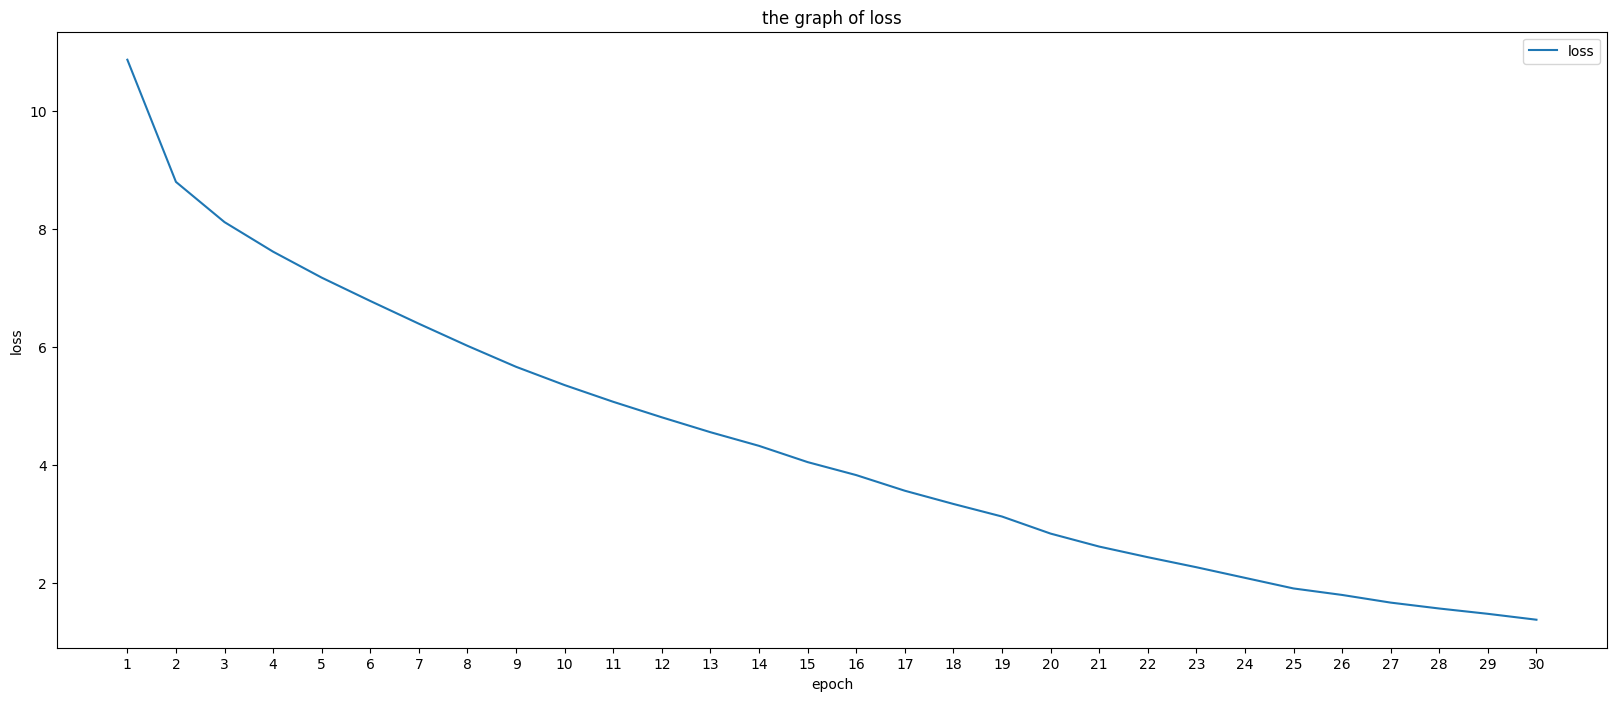

In [92]:
# putting losses in a dataframe
loss_df= pd.DataFrame({"epoch": range(1, len(losses)+1), "loss": losses})
loss_df.set_index('epoch', inplace=True)
display(loss_df)

#plotting losses
loss_df.plot(figsize=(20,8))
plt.ylabel('loss')
plt.xticks(range(1, 31))
plt.title("the graph of loss")
plt.show()